# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install zipfile -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 1
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64
import warnings
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics
from dinglingling import wx_reminder

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    correct_column_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# global variables
SCKEY = 'SCU92138T03d57ff9d4b08ced24c2cceb440cd3bd5e843242680de'  # used for reminding when feature engineering or model training completes

In [4]:
# functions
def __dummy():
    pass

@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def feature_engineering_wrapper(params):
        """
        wrapper for feature engineering func 
        for reminding when it completes
        """
        fe_df = feature_engineering(**params)
        
        return fe_df    
    
@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def tune_params_wrapper(params):
    results, best_params , feats_imp = train(**params) 
    return results, best_params, feats_imp

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

8.1M	../data/2017_fault_data.h5
67M	../data/chunk_data_for_test.h5
4.2G	../data/code.zip
4.2G	../data/data_2017_all.h5
4.7G	../data/data_2017_new_all.h5
2.3G	../data/data_2017_tag_flag.h5
2.5G	../data/data_2017_tag_flag_raw.h5
12G	../data/data_2017_to_2018_all.h5
20M	../data/data_201808_test.h5
41M	../data/data_201808_test_all.h5
46M	../data/data_201808_test_b.h5
24M	../data/data_201808_test_raw.h5
6.9G	../data/data_2018_all.h5
7.9G	../data/data_2018_new_all.h5
2.5G	../data/data_2018_semifinals.h5
9.1G	../data/data_2018_semifinals_all.h5
3.9G	../data/data_2018_tag_flag.h5
4.2G	../data/data_2018_tag_flag_raw.h5
36K	../data/disk_sample_fault_tag.csv
8.0K	../data/disk_sample_fault_tag_201808.csv
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G

In [6]:
# feature engineering
params = {
    'filename':'data_2018_semifinals_all.h5', # file we want to load for feature engineering
    'fe_save_filename':'fe_df_01_01_round_2_with_smart_9raw.feather',  # naming the train fe by the start date of train not include 2017 data date
    'use_2017_fault_data':True,
    'clip_start_date': '2018-01-01', # start date of data for doing feature engineering(not include 2017 data) e.g. 2018-02-01 
    'clip_end_date': '2018-08-31',  # end date of data for doing feature engineering e.g. 2018-06-30
    'use_model_id': None,  # 1,2 and None
    'is_train':True,
    'num_processes': 30,
}

fe_df = feature_engineering_wrapper(params)

2020-04-10 18:28:49,668 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-10 18:28:49,670 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: True，数据集截断起始日期：2018-01-01, 数据集截断结束日期：2018-08-31
2020-04-10 18:28:49,672 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-10 18:28:49,673 - mlpipeline.feature_engineering - INFO - 加载数据集: ../data/data_2018_semifinals_all.h5
2020-04-10 18:31:51,113 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['smart_1_normalized', 'smart_3_normalized', 'smart_7_normalized', 'smart_184_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_191_normalized',
       'smart_195_normalized', 'smart_4raw', 'smart_5raw', 'smart_9raw', 'smart_12raw',
       'smart_188raw', 'smart_192raw', 'smart_194raw', 'smart_197raw', 'smart_198raw',
       'smart_199raw', 'dt', 'serial_number', 'model', 'tag', 'flag'],
      dtype='object')
2020-04-10 18:31:51,117 - mlpipeline.feature_engineering - INFO - 加载

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning

2020-04-10 19:59:04,424 - utils.utils - INFO - smart_188raw - 0.0%
2020-04-10 19:59:04,471 - utils.utils - INFO - smart_199raw - 0.0%
2020-04-10 19:59:04,531 - utils.utils - INFO - smart_1_normalized - 0.0%
2020-04-10 19:59:04,590 - utils.utils - INFO - smart_3_normalized - 0.0%
2020-04-10 19:59:04,646 - utils.utils - INFO - smart_7_normalized - 0.0%
2020-04-10 19:59:04,705 - utils.utils - INFO - smart_195_normalized - 0.0%
2020-04-10 19:59:04,768 - utils.utils - INFO - smart_4raw - 0.0%
2020-04-10 19:59:04,825 - utils.utils - INFO - smart_5raw - 0.0%
2020-04-10 19:59:04,881 - utils.utils - INFO - smart_12raw - 0.0%
2020-04-10 19:59:04,940 - utils.utils - INFO - smart_192raw - 0.0%
2020-04-10 19:59:04,997 - utils.utils - INFO - smart_194raw - 0.0%
2020-04-10 19:59:05,081 - utils.utils - INFO - err_weight - 0.0%
2020-04-10 19:59:05,170 - utils.utils - INFO - seek_err_weight - 0.0%
2020-04-10 19:59:05,253 - utils.utils - INFO - degradation_err_weight - 0.0%
2020-04-10 19:59:05,301 - util

In [6]:
# drop_cols = ['smart_191_normalized_diff_for_last_period_7',
#             'smart_7_normalized_diff_for_last_period_7',
#             'smart_192raw_diff_for_last_period_7',
#             'smart_199raw_diff_for_last_period_7',
#             'smart_195_normalized_diff_for_last_period_7',
#             'smart_193_normalized_diff_for_last_period_7',
#             'smart_189_normalized_diff_for_last_period_7',
#             'smart_4raw_diff_for_last_period_7',
#             'smart_194raw_diff_for_last_period_7',
#             'smart_12raw_diff_for_last_period_7',
#             'smart_3_normalized_diff_for_last_period_7',
#             'smart_1_normalized_diff_for_last_period_7',    
#             'degradation_err_weight_diff_for_last_period_7',
#             'seek_err_weight_diff_for_last_period_7',
# #             'smart_9raw_in_day_unit_cate'
#             ]
# drop_cols =  ['seek_err_weight_min_7', 'smart_195_normalized_max_7',
#        'smart_12raw_max_7', 'power_on_hours_in_day_unit_cate',
#        'err_weight_min_7', 'seek_err_weight', 'smart_195_normalized',
#        'smart_3_normalized_mean_7', 'smart_5raw_max_7', 'smart_12raw',
#        'smart_1_normalized_std_7', 'smart_4raw_mean_7',
#        'smart_187_normalized', 'smart_12raw_std_7', 'err_weight_std_7',
#        'smart_192raw_max_7', 'degradation_err_weight',
#        'smart_194raw_max_7', 'smart_195_normalized_mean_7',
#        'smart_192raw_mean_7', 'smart_194raw_mean_7', 'smart_192raw_std_7',
#        'smart_4raw_max_7', 'smart_4raw_std_7', 'smart_7_normalized_min_7',
#        'smart_194raw_min_7', 'smart_195_normalized_min_7',
#        'degradation_err_weight_std_7', 'smart_192raw', 'smart_5raw_min_7',
#        'smart_3_normalized_std_7', 'smart_192raw_min_7', 'smart_197raw',
#        'smart_7_normalized_std_7', 'err_weight_diff_for_last_period_7',
#        'smart_12raw_mean_7', 'smart_194raw', 'smart_1_normalized_max_7',
#        'smart_1_normalized_mean_7', 'smart_5raw_mean_7',
#        'smart_195_normalized_std_7', 'smart_184_normalized',
#        'seek_err_weight_mean_7', 'smart_194raw_std_7',
#        'smart_191_normalized', 'smart_3_normalized_min_7', 'smart_4raw',
#        'smart_3_normalized', 'smart_1_normalized_min_7', 'smart_198raw',
#        'err_weight_slope_for_last_duration_7', 'seek_err_weight_std_7',
#        'model_type', 'degradation_err_weight_diff_for_last_period_7',
#        'smart_1_normalized', 'seek_err_weight_diff_for_last_period_7']
drop_cols = []

In [7]:
# tune params
search_params_space = {
                'scale_pos_weight':[20,25,30,40,45,50],
                'num_leaves':[16,32,64,128],  # [16,32,64,128]
                'subsample':(0.7,0.99),  # [0.7,0.8,0.9,1]
                'colsample_bytree':(0.3,0.71), # [0.2,0.3,0.4,0.5,0.6]
                'min_data_in_leaf':[20,40,60,80,100,120], # [20,40,60,80,100]
                'lambda_l1':(0.2,3.5),  # (0.2,3)
                'lambda_l2':(0.2,3.5),  # (0.2,3)
#                 'focal_loss_alpha':[i*0.1 for i in range(5, 10)],
#                 'focal_loss_gamma':[i*0.1 for i in range(1, 30)]
}

model_params = {
               'objective': 'binary',
               'boosting': 'gbdt',
               'learning_rate': 0.001,
               'metric': ['auc'],
               'num_threads': 15,
               'random_state': 2019,
               'num_boost_round': 1000,
               'device': 'cpu',}

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_log': False,
    'drop_cols':drop_cols,
    'random_state':1,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'use_2017_fault_data':True,
    'use_next_month_fault_data':True,
    'use_random_search':True,
    'use_cv':False,
    'random_search_times':20,
    'search_params_space':search_params_space,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
#     'train_date_list':[
#                       ('2018-01-01','2018-01-31'),
#                       ('2018-01-01','2018-02-28'),
#                       ('2018-01-01','2018-03-31'),
#                       ('2018-02-01','2018-04-30'),
#                       ('2018-01-01','2018-05-31')     
#     ],
#     'val_date_list':[
#                       ('2018-03-01','2018-03-31'),
#                       ('2018-04-01','2018-04-30'),
#                       ('2018-05-01','2018-05-31'),
#                       ('2018-06-01','2018-06-30'),
#                       ('2018-07-01','2018-07-31')
#      ],
#      'n_fold':5
}

2020-04-10 22:10:18,804 - mlpipeline.train - INFO - train开始
2020-04-10 22:10:18,806 - mlpipeline.train - INFO - 当前模式:eval, eval on model None, train on model None, 使用的数据集:sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather, 当前使用模型:lgb, 使用cv: False, use_random_search: True, 训练集日期:2018-01-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 40, 下采样：False, 上采样：False, 用的label：tag
2020-04-10 22:10:20,938 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-10 22:10:20,941 - mlpipeline.train - INFO - 连续性特征数量: 67
2020-04-10 22:10:20,942 - mlpipeline.train - INFO - 离散性特征数量: 9
2020-04-10 22:10:59,831 - mlpipeline.train - INFO - 训练集正负样本比:24917:6651643(i.e. 0.00375)
2020-04-10 22:10:59,911 - mlpipeline.train - INFO - 验证集正负样本比:4433:4851262(i.e. 0.00091)
  0%|          | 0/20 [00:00<?, ?it/s]2020-04-10 22:10:59,915 - mlpipeline.train - INFO - eval参数: {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'metric': ['auc'], 'num_threads': 15, 'rand

[1]	training's auc: 0.756697	valid_1's auc: 0.717539
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.781836	valid_1's auc: 0.725334
[3]	training's auc: 0.796786	valid_1's auc: 0.725171
[4]	training's auc: 0.803936	valid_1's auc: 0.717262
[5]	training's auc: 0.809291	valid_1's auc: 0.722897
[6]	training's auc: 0.810874	valid_1's auc: 0.728592
[7]	training's auc: 0.811786	valid_1's auc: 0.726411
[8]	training's auc: 0.815141	valid_1's auc: 0.730421
[9]	training's auc: 0.814916	valid_1's auc: 0.729922
[10]	training's auc: 0.819631	valid_1's auc: 0.733929
[11]	training's auc: 0.821808	valid_1's auc: 0.734722
[12]	training's auc: 0.826876	valid_1's auc: 0.736302
[13]	training's auc: 0.829127	valid_1's auc: 0.733121
[14]	training's auc: 0.830762	valid_1's auc: 0.732215
[15]	training's auc: 0.833215	valid_1's auc: 0.731359
[16]	training's auc: 0.834543	valid_1's auc: 0.731158
[17]	training's auc: 0.835363	valid_1's auc: 0.731744
[18]	training's auc: 0.835673

2020-04-10 22:12:14,673 - mlpipeline.train - INFO - eval最优轮数: 12, eval最优auc: 0.7363016479817793
2020-04-10 22:12:14,675 - mlpipeline.train - INFO - 模型训练用时:0:01:15
2020-04-10 22:12:14,688 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  1.062966e+08                               err_weight_max_7
73  3.072409e+07                                     err_weight
54  1.292379e+07                              err_weight_mean_7
63  7.523034e+06                             smart_9_normalized
6   7.194556e+06                                   smart_199raw
23  6.525678e+06                       smart_7_normalized_max_7
5   6.330487e+06                                   smart_188raw
38  5.998856e+06                               smart_5raw_std_7
15  5.521279e+06                              smart_12raw_min_7
32  4.539027e+06                   degradation_err_weight_max_7
47  4.477100e+06                      smart_7_normalized_mean_7
57  3.13809

[22]	training's auc: 0.843478	valid_1's auc: 0.728414
Early stopping, best iteration is:
[12]	training's auc: 0.826876	valid_1's auc: 0.736302


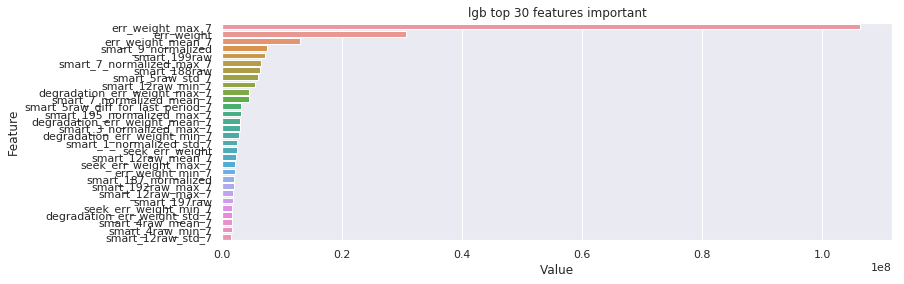

2020-04-10 22:12:23,942 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:12:24,872 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:12:24,874 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:12:25,809 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:12:25,810 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:12:26,743 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:12:26,744 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:12:27,679 - mlpipeline.train - INFO - 原始预测为fault disk的个数：640
2020-04-10 22:12:27,680 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:12:28,632 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:12:28,633 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:12:29,584 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-10 22:12:29,585 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.820934	valid_1's auc: 0.714024
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.845292	valid_1's auc: 0.722728
[3]	training's auc: 0.865154	valid_1's auc: 0.739074
[4]	training's auc: 0.871444	valid_1's auc: 0.735431
[5]	training's auc: 0.883331	valid_1's auc: 0.732729
[6]	training's auc: 0.88798	valid_1's auc: 0.733527
[7]	training's auc: 0.892653	valid_1's auc: 0.731139
[8]	training's auc: 0.895361	valid_1's auc: 0.7304
[9]	training's auc: 0.898642	valid_1's auc: 0.727072
[10]	training's auc: 0.899346	valid_1's auc: 0.727033
[11]	training's auc: 0.906419	valid_1's auc: 0.722892
[12]	training's auc: 0.908687	valid_1's auc: 0.722933


2020-04-10 22:13:58,319 - mlpipeline.train - INFO - eval最优轮数: 3, eval最优auc: 0.7390738839940365
2020-04-10 22:13:58,321 - mlpipeline.train - INFO - 模型训练用时:0:02:59
2020-04-10 22:13:58,331 - mlpipeline.train - INFO - 特征重要性：         Value                                        Feature
30  97583001.0                               err_weight_max_7
73  30671628.0                                     err_weight
47   8827078.0                      smart_7_normalized_mean_7
5    7581139.0                                   smart_188raw
15   6854711.0                              smart_12raw_min_7
20   5580365.0                   degradation_err_weight_min_7
56   5479567.0                  degradation_err_weight_mean_7
32   5011206.0                   degradation_err_weight_max_7
63   5008051.0                             smart_9_normalized
25   4053849.0                               smart_4raw_max_7
6    3775340.0                                   smart_199raw
24   3538903.0                     s

[13]	training's auc: 0.910009	valid_1's auc: 0.72266
Early stopping, best iteration is:
[3]	training's auc: 0.865154	valid_1's auc: 0.739074


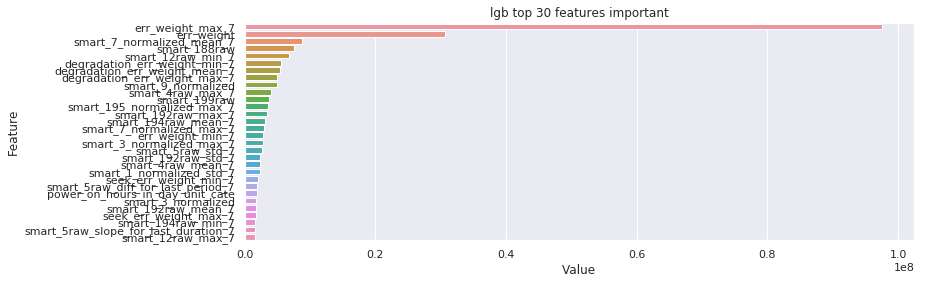

2020-04-10 22:14:06,985 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:14:07,896 - mlpipeline.train - INFO - 原始预测为fault disk的个数：631
2020-04-10 22:14:07,897 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:14:08,799 - mlpipeline.train - INFO - 原始预测为fault disk的个数：629
2020-04-10 22:14:08,800 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:14:09,706 - mlpipeline.train - INFO - 原始预测为fault disk的个数：635
2020-04-10 22:14:09,707 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:14:10,620 - mlpipeline.train - INFO - 原始预测为fault disk的个数：631
2020-04-10 22:14:10,621 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:14:11,544 - mlpipeline.train - INFO - 原始预测为fault disk的个数：637
2020-04-10 22:14:11,545 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:14:12,452 - mlpipeline.train - INFO - 原始预测为fault disk的个数：639
2020-04-10 22:14:12,453 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.733893	valid_1's auc: 0.704924
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.75215	valid_1's auc: 0.724678
[3]	training's auc: 0.756019	valid_1's auc: 0.724835
[4]	training's auc: 0.75878	valid_1's auc: 0.723922
[5]	training's auc: 0.761368	valid_1's auc: 0.726898
[6]	training's auc: 0.763225	valid_1's auc: 0.731746
[7]	training's auc: 0.763293	valid_1's auc: 0.73124
[8]	training's auc: 0.763766	valid_1's auc: 0.731421
[9]	training's auc: 0.762661	valid_1's auc: 0.730203
[10]	training's auc: 0.763316	valid_1's auc: 0.730244
[11]	training's auc: 0.763246	valid_1's auc: 0.730184
[12]	training's auc: 0.764906	valid_1's auc: 0.732281
[13]	training's auc: 0.766827	valid_1's auc: 0.730945
[14]	training's auc: 0.770593	valid_1's auc: 0.730659
[15]	training's auc: 0.774953	valid_1's auc: 0.731845
[16]	training's auc: 0.776036	valid_1's auc: 0.732414
[17]	training's auc: 0.776567	valid_1's auc: 0.732944
[18]	training's auc: 0.777044	va

2020-04-10 22:16:45,123 - mlpipeline.train - INFO - eval最优轮数: 72, eval最优auc: 0.7445373336848852
2020-04-10 22:16:45,124 - mlpipeline.train - INFO - 模型训练用时:0:05:45
2020-04-10 22:16:45,135 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  1.413543e+08                               err_weight_max_7
73  4.790797e+07                                     err_weight
26  4.017372e+07                               smart_5raw_max_7
54  1.753167e+07                              err_weight_mean_7
63  1.249897e+07                             smart_9_normalized
5   1.212682e+07                                   smart_188raw
47  1.002128e+07                      smart_7_normalized_mean_7
6   9.567132e+06                                   smart_199raw
23  9.202713e+06                       smart_7_normalized_max_7
69  8.983666e+06                                     smart_5raw
18  8.484484e+06                               err_weight_min_7
50  8.41517

[82]	training's auc: 0.807582	valid_1's auc: 0.744498
Early stopping, best iteration is:
[72]	training's auc: 0.802792	valid_1's auc: 0.744537


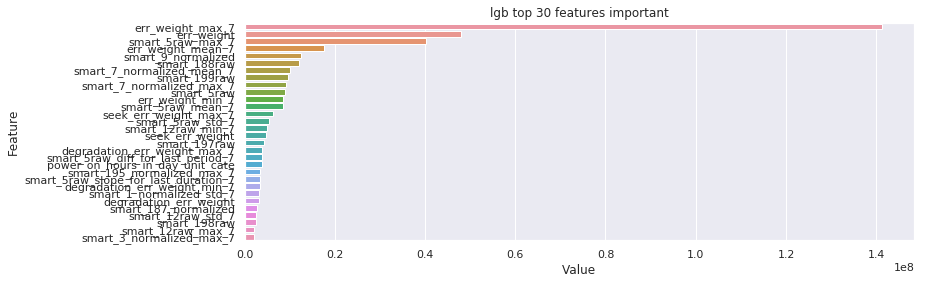

2020-04-10 22:16:53,819 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:16:54,824 - mlpipeline.train - INFO - 原始预测为fault disk的个数：640
2020-04-10 22:16:54,826 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:16:55,834 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:16:55,835 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:16:56,825 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-10 22:16:56,827 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:16:57,805 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-10 22:16:57,817 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:16:59,190 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:16:59,192 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:17:00,380 - mlpipeline.train - INFO - 原始预测为fault disk的个数：647
2020-04-10 22:17:00,381 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.735579	valid_1's auc: 0.705055
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.759848	valid_1's auc: 0.722144
[3]	training's auc: 0.764316	valid_1's auc: 0.730542
[4]	training's auc: 0.770988	valid_1's auc: 0.729259
[5]	training's auc: 0.772751	valid_1's auc: 0.730133
[6]	training's auc: 0.774349	valid_1's auc: 0.729374
[7]	training's auc: 0.778315	valid_1's auc: 0.73067
[8]	training's auc: 0.777491	valid_1's auc: 0.726324
[9]	training's auc: 0.778848	valid_1's auc: 0.737613
[10]	training's auc: 0.779056	valid_1's auc: 0.737108
[11]	training's auc: 0.781779	valid_1's auc: 0.737927
[12]	training's auc: 0.783158	valid_1's auc: 0.738406
[13]	training's auc: 0.788638	valid_1's auc: 0.740277
[14]	training's auc: 0.79046	valid_1's auc: 0.740192
[15]	training's auc: 0.79418	valid_1's auc: 0.739376
[16]	training's auc: 0.795831	valid_1's auc: 0.73797
[17]	training's auc: 0.796658	valid_1's auc: 0.736028
[18]	training's auc: 0.796315	val

2020-04-10 22:18:36,313 - mlpipeline.train - INFO - eval最优轮数: 13, eval最优auc: 0.74027715186471
2020-04-10 22:18:36,315 - mlpipeline.train - INFO - 模型训练用时:0:07:37
2020-04-10 22:18:36,332 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  7.362252e+07                               err_weight_max_7
54  1.532936e+07                              err_weight_mean_7
69  1.345904e+07                                     smart_5raw
26  1.277272e+07                               smart_5raw_max_7
73  6.674037e+06                                     err_weight
47  6.319814e+06                      smart_7_normalized_mean_7
57  5.952379e+06              smart_5raw_diff_for_last_period_7
5   4.059707e+06                                   smart_188raw
6   3.716058e+06                                   smart_199raw
38  3.144727e+06                               smart_5raw_std_7
31  3.039767e+06                          seek_err_weight_max_7
62  2.403757e

[23]	training's auc: 0.800115	valid_1's auc: 0.733802
Early stopping, best iteration is:
[13]	training's auc: 0.788638	valid_1's auc: 0.740277


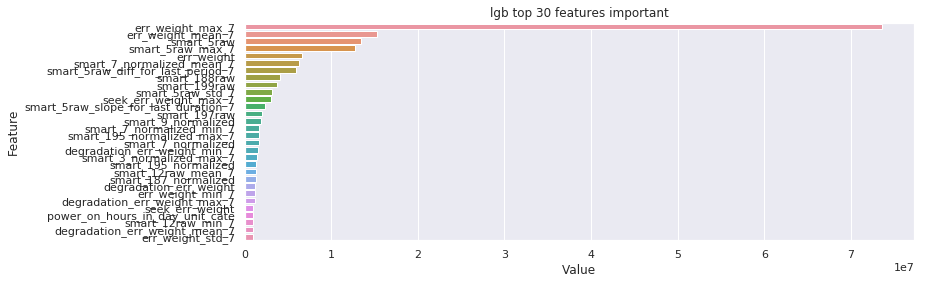

2020-04-10 22:18:45,310 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:18:46,237 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:18:46,238 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:18:47,466 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-10 22:18:47,467 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:18:48,644 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-10 22:18:48,645 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:18:49,646 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-10 22:18:49,648 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:18:50,595 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:18:50,596 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:18:51,536 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-10 22:18:51,537 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.733795	valid_1's auc: 0.710344
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.742253	valid_1's auc: 0.723075
[3]	training's auc: 0.75725	valid_1's auc: 0.723488
[4]	training's auc: 0.762008	valid_1's auc: 0.724774
[5]	training's auc: 0.766048	valid_1's auc: 0.737269
[6]	training's auc: 0.767683	valid_1's auc: 0.73668
[7]	training's auc: 0.769919	valid_1's auc: 0.735715
[8]	training's auc: 0.771728	valid_1's auc: 0.737387
[9]	training's auc: 0.772672	valid_1's auc: 0.736346
[10]	training's auc: 0.776291	valid_1's auc: 0.735118
[11]	training's auc: 0.780219	valid_1's auc: 0.734648
[12]	training's auc: 0.780845	valid_1's auc: 0.735196
[13]	training's auc: 0.780688	valid_1's auc: 0.735554
[14]	training's auc: 0.781433	valid_1's auc: 0.735928
[15]	training's auc: 0.783302	valid_1's auc: 0.736682
[16]	training's auc: 0.786843	valid_1's auc: 0.736589
[17]	training's auc: 0.786765	valid_1's auc: 0.736501
[18]	training's auc: 0.788598	v

2020-04-10 22:21:03,705 - mlpipeline.train - INFO - eval最优轮数: 49, eval最优auc: 0.7436847021561699
2020-04-10 22:21:03,707 - mlpipeline.train - INFO - 模型训练用时:0:10:04
2020-04-10 22:21:03,718 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  2.020049e+08                               err_weight_max_7
26  5.510260e+07                               smart_5raw_max_7
73  4.189969e+07                                     err_weight
54  2.293381e+07                              err_weight_mean_7
63  2.102228e+07                             smart_9_normalized
5   1.947208e+07                                   smart_188raw
31  1.375454e+07                          seek_err_weight_max_7
47  1.262167e+07                      smart_7_normalized_mean_7
18  1.052412e+07                               err_weight_min_7
23  9.823436e+06                       smart_7_normalized_max_7
69  9.766546e+06                                     smart_5raw
6   9.76021

[59]	training's auc: 0.807731	valid_1's auc: 0.742386
Early stopping, best iteration is:
[49]	training's auc: 0.804837	valid_1's auc: 0.743685


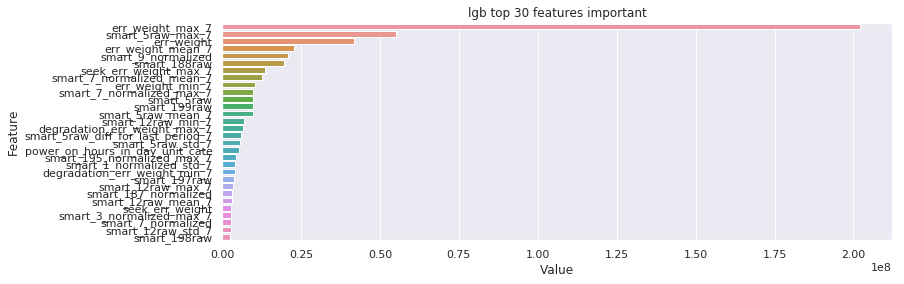

2020-04-10 22:21:12,246 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:21:13,223 - mlpipeline.train - INFO - 原始预测为fault disk的个数：536
2020-04-10 22:21:13,224 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:21:14,188 - mlpipeline.train - INFO - 原始预测为fault disk的个数：531
2020-04-10 22:21:14,189 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:21:15,159 - mlpipeline.train - INFO - 原始预测为fault disk的个数：529
2020-04-10 22:21:15,160 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:21:16,120 - mlpipeline.train - INFO - 原始预测为fault disk的个数：529
2020-04-10 22:21:16,122 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:21:17,094 - mlpipeline.train - INFO - 原始预测为fault disk的个数：528
2020-04-10 22:21:17,096 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:21:18,058 - mlpipeline.train - INFO - 原始预测为fault disk的个数：532
2020-04-10 22:21:18,059 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.738557	valid_1's auc: 0.70963
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.761091	valid_1's auc: 0.726535
[3]	training's auc: 0.764784	valid_1's auc: 0.735999
[4]	training's auc: 0.771595	valid_1's auc: 0.734679
[5]	training's auc: 0.770969	valid_1's auc: 0.737893
[6]	training's auc: 0.771715	valid_1's auc: 0.737583
[7]	training's auc: 0.774389	valid_1's auc: 0.738605
[8]	training's auc: 0.775031	valid_1's auc: 0.737443
[9]	training's auc: 0.775609	valid_1's auc: 0.739053
[10]	training's auc: 0.776128	valid_1's auc: 0.740684
[11]	training's auc: 0.778061	valid_1's auc: 0.738065
[12]	training's auc: 0.77952	valid_1's auc: 0.739317
[13]	training's auc: 0.782806	valid_1's auc: 0.740251
[14]	training's auc: 0.786386	valid_1's auc: 0.738982
[15]	training's auc: 0.787739	valid_1's auc: 0.738685
[16]	training's auc: 0.788302	valid_1's auc: 0.738289
[17]	training's auc: 0.788761	valid_1's auc: 0.738095
[18]	training's auc: 0.7886	val

2020-04-10 22:22:48,729 - mlpipeline.train - INFO - eval最优轮数: 10, eval最优auc: 0.7406837226848477
2020-04-10 22:22:48,730 - mlpipeline.train - INFO - 模型训练用时:0:11:49
2020-04-10 22:22:48,738 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  7.313405e+07                               err_weight_max_7
69  1.350359e+07                                     smart_5raw
54  1.027893e+07                              err_weight_mean_7
26  8.082100e+06                               smart_5raw_max_7
73  6.920706e+06                                     err_weight
47  6.623829e+06                      smart_7_normalized_mean_7
5   3.925883e+06                                   smart_188raw
62  3.235146e+06           smart_5raw_slope_for_last_duration_7
57  2.568451e+06              smart_5raw_diff_for_last_period_7
38  2.499739e+06                               smart_5raw_std_7
63  2.350305e+06                             smart_9_normalized
32  2.27789

[20]	training's auc: 0.791418	valid_1's auc: 0.736412
Early stopping, best iteration is:
[10]	training's auc: 0.776128	valid_1's auc: 0.740684


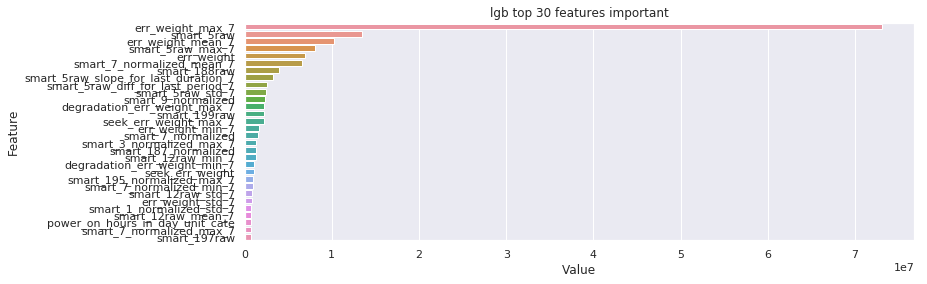

2020-04-10 22:22:57,452 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:22:58,810 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:22:58,811 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:22:59,838 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-10 22:22:59,839 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:23:00,760 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-10 22:23:00,761 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:23:01,673 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-10 22:23:01,674 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:23:02,604 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:23:02,605 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:23:03,519 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-10 22:23:03,520 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.733706	valid_1's auc: 0.710212
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.742237	valid_1's auc: 0.723038
[3]	training's auc: 0.756322	valid_1's auc: 0.732279
[4]	training's auc: 0.761513	valid_1's auc: 0.733465
[5]	training's auc: 0.763722	valid_1's auc: 0.731753
[6]	training's auc: 0.765498	valid_1's auc: 0.731241
[7]	training's auc: 0.767174	valid_1's auc: 0.73271
[8]	training's auc: 0.770902	valid_1's auc: 0.7313
[9]	training's auc: 0.771172	valid_1's auc: 0.732623
[10]	training's auc: 0.772515	valid_1's auc: 0.730835
[11]	training's auc: 0.773481	valid_1's auc: 0.730556
[12]	training's auc: 0.774308	valid_1's auc: 0.732385
[13]	training's auc: 0.777016	valid_1's auc: 0.73289
[14]	training's auc: 0.777762	valid_1's auc: 0.73504
[15]	training's auc: 0.780479	valid_1's auc: 0.736162
[16]	training's auc: 0.783456	valid_1's auc: 0.736763
[17]	training's auc: 0.783592	valid_1's auc: 0.737159
[18]	training's auc: 0.784215	vali

2020-04-10 22:24:50,642 - mlpipeline.train - INFO - eval最优轮数: 27, eval最优auc: 0.7434590221254139
2020-04-10 22:24:50,644 - mlpipeline.train - INFO - 模型训练用时:0:13:51
2020-04-10 22:24:50,658 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
30  174518179.0                               err_weight_max_7
26   39907568.0                               smart_5raw_max_7
69   30922582.0                                     smart_5raw
73   22628256.0                                     err_weight
54   21684592.0                              err_weight_mean_7
5    14917374.0                                   smart_188raw
47   12262140.0                      smart_7_normalized_mean_7
63   11413861.0                             smart_9_normalized
18    9529970.0                               err_weight_min_7
23    8468840.0                       smart_7_normalized_max_7
6     8116892.0                                   smart_199raw
31    6394422.0        

[37]	training's auc: 0.7979	valid_1's auc: 0.742814
Early stopping, best iteration is:
[27]	training's auc: 0.79252	valid_1's auc: 0.743459


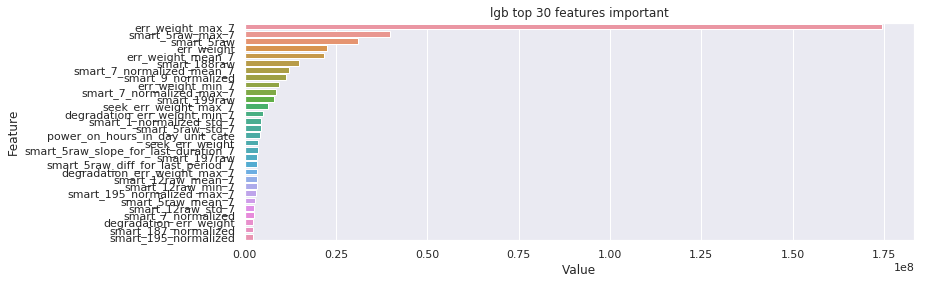

2020-04-10 22:24:59,272 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:25:00,218 - mlpipeline.train - INFO - 原始预测为fault disk的个数：649
2020-04-10 22:25:00,220 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:25:01,158 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-10 22:25:01,159 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:25:02,106 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-10 22:25:02,108 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:25:03,041 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-10 22:25:03,042 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:25:03,973 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-10 22:25:03,974 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:25:04,902 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-10 22:25:04,904 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.77834	valid_1's auc: 0.714627
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.798791	valid_1's auc: 0.715819
[3]	training's auc: 0.820596	valid_1's auc: 0.727336
[4]	training's auc: 0.830568	valid_1's auc: 0.741142
[5]	training's auc: 0.839084	valid_1's auc: 0.73951
[6]	training's auc: 0.839349	valid_1's auc: 0.739031
[7]	training's auc: 0.84199	valid_1's auc: 0.73872
[8]	training's auc: 0.849704	valid_1's auc: 0.73602
[9]	training's auc: 0.851741	valid_1's auc: 0.735385
[10]	training's auc: 0.852156	valid_1's auc: 0.737584
[11]	training's auc: 0.856446	valid_1's auc: 0.738186
[12]	training's auc: 0.858449	valid_1's auc: 0.739293
[13]	training's auc: 0.861086	valid_1's auc: 0.739813


2020-04-10 22:26:33,176 - mlpipeline.train - INFO - eval最优轮数: 4, eval最优auc: 0.7411419058852974
2020-04-10 22:26:33,178 - mlpipeline.train - INFO - 模型训练用时:0:15:33
2020-04-10 22:26:33,190 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
30  113282825.0                               err_weight_max_7
69   27447597.0                                     smart_5raw
47    8674726.0                      smart_7_normalized_mean_7
5     8313304.0                                   smart_188raw
63    6314095.0                             smart_9_normalized
32    4778814.0                   degradation_err_weight_max_7
66    4400690.0                             smart_7_normalized
20    4091980.0                   degradation_err_weight_min_7
62    3764508.0           smart_5raw_slope_for_last_duration_7
70    2992499.0                                    smart_12raw
25    2778797.0                               smart_4raw_max_7
46    2767389.0         

[14]	training's auc: 0.863208	valid_1's auc: 0.740227
Early stopping, best iteration is:
[4]	training's auc: 0.830568	valid_1's auc: 0.741142


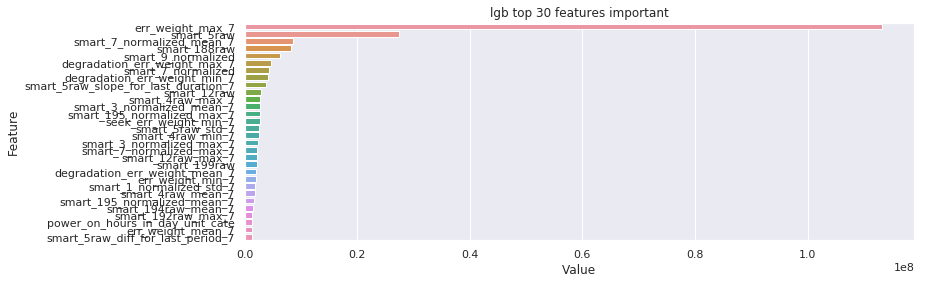

2020-04-10 22:26:42,406 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-10 22:26:43,337 - mlpipeline.train - INFO - 原始预测为fault disk的个数：636
2020-04-10 22:26:43,338 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-10 22:26:44,363 - mlpipeline.train - INFO - 原始预测为fault disk的个数：632
2020-04-10 22:26:44,364 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-10 22:26:45,302 - mlpipeline.train - INFO - 原始预测为fault disk的个数：638
2020-04-10 22:26:45,303 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-10 22:26:46,256 - mlpipeline.train - INFO - 原始预测为fault disk的个数：638
2020-04-10 22:26:46,257 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-10 22:26:47,197 - mlpipeline.train - INFO - 原始预测为fault disk的个数：639
2020-04-10 22:26:47,199 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-10 22:26:48,160 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-10 22:26:48,161 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-10 

[1]	training's auc: 0.804528	valid_1's auc: 0.701409
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.835113	valid_1's auc: 0.724514
[3]	training's auc: 0.856485	valid_1's auc: 0.730067
[4]	training's auc: 0.86726	valid_1's auc: 0.733965
[5]	training's auc: 0.875299	valid_1's auc: 0.738549
[6]	training's auc: 0.878159	valid_1's auc: 0.735965
[7]	training's auc: 0.881202	valid_1's auc: 0.737004
[8]	training's auc: 0.887869	valid_1's auc: 0.7383
[9]	training's auc: 0.895553	valid_1's auc: 0.734608
[10]	training's auc: 0.898222	valid_1's auc: 0.741144
[11]	training's auc: 0.902577	valid_1's auc: 0.741314
[12]	training's auc: 0.905961	valid_1's auc: 0.742975
[13]	training's auc: 0.907631	valid_1's auc: 0.743932
[14]	training's auc: 0.909396	valid_1's auc: 0.744598
[15]	training's auc: 0.911902	valid_1's auc: 0.744543
[16]	training's auc: 0.914288	valid_1's auc: 0.743126
[17]	training's auc: 0.917148	valid_1's auc: 0.741784
[18]	training's auc: 0.919162	va

In [ ]:
results,best_params, feats_imp = tune_params_wrapper(params) 

In [25]:
results[0]

{'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.001,
 'metric': ['auc'],
 'num_threads': 15,
 'random_state': 2019,
 'num_boost_round': 1000,
 'device': 'cpu',
 'scale_pos_weight': 20,
 'num_leaves': 64,
 'subsample': 0.8836336288297502,
 'colsample_bytree': 0.7413724760134791,
 'min_data_in_leaf': 20,
 'lambda_l1': 2.2937283445442778,
 'lambda_l2': 2.0629293244080618,
 'f1_score': 0.22448181462651542,
 'n_estimators': 12}

In [14]:
feats_imp.iloc[20:]['Feature'].values

array(['seek_err_weight_min_7', 'smart_195_normalized_max_7',
       'smart_12raw_max_7', 'power_on_hours_in_day_unit_cate',
       'err_weight_min_7', 'seek_err_weight', 'smart_195_normalized',
       'smart_3_normalized_mean_7', 'smart_5raw_max_7', 'smart_12raw',
       'smart_1_normalized_std_7', 'smart_4raw_mean_7',
       'smart_187_normalized', 'smart_12raw_std_7', 'err_weight_std_7',
       'smart_192raw_max_7', 'degradation_err_weight',
       'smart_194raw_max_7', 'smart_195_normalized_mean_7',
       'smart_192raw_mean_7', 'smart_194raw_mean_7', 'smart_192raw_std_7',
       'smart_4raw_max_7', 'smart_4raw_std_7', 'smart_7_normalized_min_7',
       'smart_194raw_min_7', 'smart_195_normalized_min_7',
       'degradation_err_weight_std_7', 'smart_192raw', 'smart_5raw_min_7',
       'smart_3_normalized_std_7', 'smart_192raw_min_7', 'smart_197raw',
       'smart_7_normalized_std_7', 'err_weight_diff_for_last_period_7',
       'smart_12raw_mean_7', 'smart_194raw', 'smart_1_normaliz

2020-04-10 22:31:04,286 - mlpipeline.train - INFO - train开始
2020-04-10 22:31:04,288 - mlpipeline.train - INFO - 当前模式:eval, eval on model None, train on model None, 使用的数据集:sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather, 当前使用模型:lgb, 使用cv: False, use_random_search: False, 训练集日期:2018-01-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 40, 下采样：False, 上采样：False, 用的label：tag
2020-04-10 22:31:06,200 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-10 22:31:06,205 - mlpipeline.train - INFO - 连续性特征数量: 67
2020-04-10 22:31:06,206 - mlpipeline.train - INFO - 离散性特征数量: 9
2020-04-10 22:31:44,645 - mlpipeline.train - INFO - 训练集正负样本比:24917:6651643(i.e. 0.00375)
2020-04-10 22:31:44,762 - mlpipeline.train - INFO - 验证集正负样本比:4433:4851262(i.e. 0.00091)
2020-04-10 22:31:44,764 - mlpipeline.train - INFO - eval参数: {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'metric': ['auc'], 'num_threads': 15, 'random_state': 2019, 'num_boost_round': 4

[1]	training's auc: 0.733795	valid_1's auc: 0.710344
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.742253	valid_1's auc: 0.723075
[3]	training's auc: 0.75725	valid_1's auc: 0.723488
[4]	training's auc: 0.762008	valid_1's auc: 0.724774
[5]	training's auc: 0.766048	valid_1's auc: 0.737269
[6]	training's auc: 0.767683	valid_1's auc: 0.73668
[7]	training's auc: 0.769919	valid_1's auc: 0.735715
[8]	training's auc: 0.771728	valid_1's auc: 0.737387
[9]	training's auc: 0.772672	valid_1's auc: 0.736346
[10]	training's auc: 0.776291	valid_1's auc: 0.735118
[11]	training's auc: 0.780219	valid_1's auc: 0.734648
[12]	training's auc: 0.780845	valid_1's auc: 0.735196
[13]	training's auc: 0.780688	valid_1's auc: 0.735554
[14]	training's auc: 0.781433	valid_1's auc: 0.735928
[15]	training's auc: 0.783302	valid_1's auc: 0.736682
[16]	training's auc: 0.786843	valid_1's auc: 0.736589
[17]	training's auc: 0.786765	valid_1's auc: 0.736501
[18]	training's auc: 0.788598	v

2020-04-10 22:33:22,302 - mlpipeline.train - INFO - eval最优轮数: 49, eval最优auc: 0.7436847021561699
2020-04-10 22:33:22,304 - mlpipeline.train - INFO - 模型训练用时:0:01:38
2020-04-10 22:33:22,313 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  2.020049e+08                               err_weight_max_7
26  5.510260e+07                               smart_5raw_max_7
73  4.189969e+07                                     err_weight
54  2.293381e+07                              err_weight_mean_7
63  2.102228e+07                             smart_9_normalized
5   1.947208e+07                                   smart_188raw
31  1.375454e+07                          seek_err_weight_max_7
47  1.262167e+07                      smart_7_normalized_mean_7
18  1.052412e+07                               err_weight_min_7
23  9.823436e+06                       smart_7_normalized_max_7
69  9.766546e+06                                     smart_5raw
6   9.76021

[49]	training's auc: 0.804837	valid_1's auc: 0.743685
Did not meet early stopping. Best iteration is:
[49]	training's auc: 0.804837	valid_1's auc: 0.743685


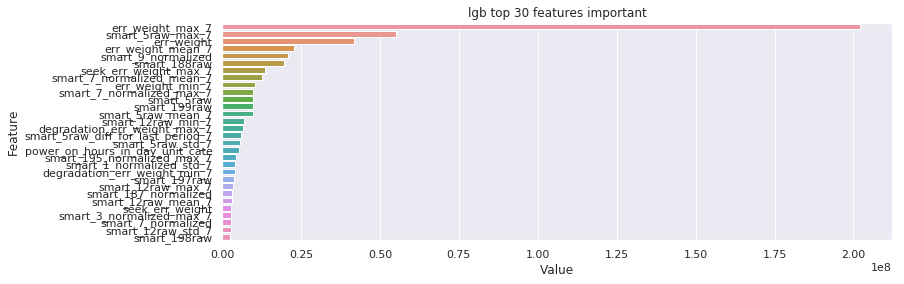

2020-04-10 22:33:30,884 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
2020-04-10 22:33:31,711 - mlpipeline.train - INFO - 原始预测为fault disk的个数：536
2020-04-10 22:33:31,712 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:

ValueError: too many values to unpack (expected 2)

In [8]:
# eval
model_params = {
                'objective': 'binary', 
                'boosting': 'gbdt', 
                'learning_rate': 0.001, 
                'metric': ['auc'],
                'num_threads': 15, 
                'random_state': 2019, 
                'num_boost_round': 49, 
                'device': 'cpu',
                'scale_pos_weight': 50, 
                'num_leaves': 16, 
                'subsample': 0.8310758942448504,
               'colsample_bytree': 0.5487172220102743,
               'min_data_in_leaf': 100, 
              'lambda_l1': 3.2344391426444883,
              'lambda_l2': 0.9849478871003188}


params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_log': False,
    'drop_cols':drop_cols,
    'use_sampling': False,
#   'use_sampling_by_month_with_weight':True,
#   'use_sampling_by_clustering_label':True,
    'use_sampling_by_power_on_hours':True,
    'use_up_sampling_by_smote':False,
    'train_sample_ratio':0.3,
    'valid_sample_ratio':None,
    'save_sample_data':True,
    'random_state':1,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'eval_on_model_id': None, # 1,2,None
    'train_on_model_id':None, # 1 ,2 , None
    'save_feat_important': False,
    'use_2017_fault_data':True,
    'use_next_month_fault_data':True,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
}
model, eval_df,feat_imp = train(**params) 

2020-04-10 22:37:01,071 - mlpipeline.train - INFO - train开始
2020-04-10 22:37:01,073 - mlpipeline.train - INFO - 当前模式:train, 使用的数据集:lgb, 当前使用模型:sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather, 训练日期:2018-01-01 - 2018-05-31
2020-04-10 22:37:02,958 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-10 22:37:02,961 - mlpipeline.train - INFO - 连续性特征数量: 67
2020-04-10 22:37:02,962 - mlpipeline.train - INFO - 离散性特征数量: 9
2020-04-10 22:37:35,963 - mlpipeline.train - INFO - 训练集正负样本比:24917:6651643(i.e. 0.00375)
2020-04-10 22:37:35,964 - mlpipeline.train - INFO - train参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'metric': ['auc'], 'num_threads': 15, 'random_state': 2019, 'num_boost_round': 49, 'device': 'cpu', 'scale_pos_weight': 50, 'num_leaves': 16, 'subsample': 0.8310758942448504, 'colsample_bytree': 0.5487172220102743, 'min_data_in_leaf': 100, 'lambda_l1': 3.2344391426444883, 'lambda_l2': 0.9849478871003188}
/opt/conda/lib/python3.7/site-p

[1]	training's auc: 0.733795
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.742253
[3]	training's auc: 0.75725
[4]	training's auc: 0.762008
[5]	training's auc: 0.766048
[6]	training's auc: 0.767683
[7]	training's auc: 0.769919
[8]	training's auc: 0.771728
[9]	training's auc: 0.772672
[10]	training's auc: 0.776291
[11]	training's auc: 0.780219
[12]	training's auc: 0.780845
[13]	training's auc: 0.780688
[14]	training's auc: 0.781433
[15]	training's auc: 0.783302
[16]	training's auc: 0.786843
[17]	training's auc: 0.786765
[18]	training's auc: 0.788598
[19]	training's auc: 0.789023
[20]	training's auc: 0.788787
[21]	training's auc: 0.789698
[22]	training's auc: 0.789816
[23]	training's auc: 0.790761
[24]	training's auc: 0.791322
[25]	training's auc: 0.791807
[26]	training's auc: 0.791848
[27]	training's auc: 0.792026
[28]	training's auc: 0.792132
[29]	training's auc: 0.792785
[30]	training's auc: 0.793443
[31]	training's auc: 0.793545
[32]	training's au

2020-04-10 22:38:37,294 - mlpipeline.train - INFO - eval最优轮数: 49, eval最优auc: 0.8048368857371563
2020-04-10 22:38:37,296 - mlpipeline.train - INFO - 模型训练用时:0:01:01
2020-04-10 22:38:37,307 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
30  2.020049e+08                               err_weight_max_7
26  5.510260e+07                               smart_5raw_max_7
73  4.189969e+07                                     err_weight
54  2.293381e+07                              err_weight_mean_7
63  2.102228e+07                             smart_9_normalized
5   1.947208e+07                                   smart_188raw
31  1.375454e+07                          seek_err_weight_max_7
47  1.262167e+07                      smart_7_normalized_mean_7
18  1.052412e+07                               err_weight_min_7
23  9.823436e+06                       smart_7_normalized_max_7
69  9.766546e+06                                     smart_5raw
6   9.76021

[49]	training's auc: 0.804837
Did not meet early stopping. Best iteration is:
[49]	training's auc: 0.804837


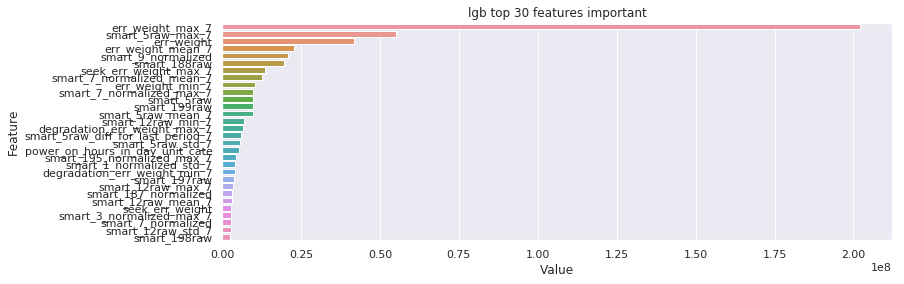

2020-04-10 22:38:38,230 - mlpipeline.train - INFO - train_pipeline_lgb已完成，共用时0:01:35
2020-04-10 22:38:38,682 - mlpipeline.train - INFO - lgb模型训练完成!模型保存至:../trained_model/lgb.model.2020-04-10T22:37:02.958533
2020-04-10 22:38:38,683 - mlpipeline.train - INFO - train已完成，共用时0:01:38


In [8]:
# train
model_params = {
                'objective': 'binary', 
                'boosting': 'gbdt', 
                'learning_rate': 0.001, 
                'metric': ['auc'],
                'num_threads': 15, 
                'random_state': 2019, 
                'num_boost_round': 49, 
                'device': 'cpu',
                'scale_pos_weight': 50, 
                'num_leaves': 16, 
                'subsample': 0.8310758942448504,
               'colsample_bytree': 0.5487172220102743,
               'min_data_in_leaf': 100, 
              'lambda_l1': 3.2344391426444883,
              'lambda_l2': 0.9849478871003188}


params = {
    'is_eval':False,
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename':  'sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather',
    'use_sampling': False,
#     'train_sample_ratio':0.4,
#     'save_sample_data':False,
#     'use_sampling_by_month_with_weight':False,
#     'use_sampling_by_clustering_label':False,
#     'use_sampling_by_power_on_hours':True,
    'random_state':1,
    'drop_cols': drop_cols,
    'train_on_model_id':None,
    'use_log': False,
    'use_next_month_fault_data':True,
    'use_2017_fault_data':True,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'train_start_date': '2018-01-01',
    'train_end_date': '2018-05-31',
#     'valid_start_date':'2018-09-01', 
}

model = train(**params)

In [8]:
# predict 
params = {
          'model_name': 'lgb',
          'pred_start_date': '2018-08-11',
          'pred_end_date':'2018-08-13',
          'num_processes':8,
          'use_log': False,
            }

submission_df = predict(**params)

2020-04-10 22:39:45,992 - mlpipeline.predict - INFO - predict开始
2020-04-10 22:39:45,995 - mlpipeline.predict - INFO - 开始预测, 当前使用模型:lgb
2020-04-10 22:39:45,996 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-10 22:39:45,997 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: False，数据集截断起始日期：None, 数据集截断结束日期：None
2020-04-10 22:39:45,998 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-10 22:39:46,000 - mlpipeline.feature_engineering - INFO - 加载数据集: ../tcdata/disk_sample_smart_log_round2
2020-04-10 22:39:46,000 - mlpipeline.feature_engineering - INFO - _get_pred_data开始
2020-04-10 22:39:46,617 - mlpipeline.feature_engineering - INFO - _get_pred_data已完成，共用时0:00:01
2020-04-10 22:39:46,620 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['serial_number', 'model', 'smart_1_normalized', 'smart_3_normalized', 'smart_4raw',
       'smart_5raw', 'smart_7_normalized', 'smart_9_normalized', 'smart_9raw', 'smart_12raw',
       'smart_184_no